Fallback .CSV

In [1]:
import pandas as pd
import mysql.connector

def load_flight_data(csv_path):

    try:
        df = pd.read_csv(csv_path)
        print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        return df
    except Exception as e:
        print("Error loading CSV:", e)
        raise

# New: MySQL loader

def load_flight_data_mysql(host, user, password, database, table):
    conn = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )

    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query, conn)

    conn.close()
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    return df

DataLoader Function SQL Modified

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
import pymysql

# MySQL credentials - update to your values
MYSQL_HOST = "127.0.0.1"  # TCP loopback recommended
MYSQL_USER = "root"
MYSQL_PASSWORD = "Romeo"
MYSQL_DATABASE = "cap4770"
MYSQL_TABLE = "airline_delay_cause"  # updated table name

# Build SQLAlchemy engine (MySQL + PyMySQL)
ENGINE_URL = f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}/{MYSQL_DATABASE}"
engine = create_engine(ENGINE_URL, pool_pre_ping=True)


def load_flight_data_mysql(host, user, password, database, table):
    url = f"mysql+pymysql://{user}:{password}@{host}/{database}"
    eng = create_engine(url, pool_pre_ping=True)
    with eng.connect() as conn:
        df = pd.read_sql(text(f"SELECT * FROM {table}"), conn)
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    return df

# Quick connectivity + row count test via SQLAlchemy
try:
    with engine.connect() as conn:
        result = conn.execute(text(f"SELECT COUNT(*) FROM {MYSQL_TABLE}"))
        count = result.scalar()
        print("Connected to MySQL via SQLAlchemy.")
        print(f"Table '{MYSQL_TABLE}' rows: {count}")
except Exception as e:
    print("MySQL (SQLAlchemy) connection failed:", e)

Connected to MySQL.
Table 'airline_delay_cause' rows: 9489


Preprocessing Function

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    df = df.copy()

    # Drop rows with all missing values
    df.dropna(how="all", inplace=True)
    df.fillna(0, inplace=True)

    # Preserve readable airport & carrier names for plots
    if "airport" in df.columns:
        df["airport_str"] = df["airport"].astype(str)
    if "carrier_name" in df.columns:
        df["carrier_name_str"] = df["carrier_name"].astype(str)

    # Label Encoding for categorical columns used in models
    cat_cols = ["carrier", "carrier_name", "airport"]
    encoder = LabelEncoder()

    for col in cat_cols:
        if col in df.columns:
            df[col] = encoder.fit_transform(df[col].astype(str))

    return df


def create_delay_label(df):
    df["delayed"] = df["arr_del15"].apply(lambda x: 1 if x >= 1 else 0)
    return df

Plots Function

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_eda(df):

    # -------------------------------
    # Plot 1 — Distribution of Delays
    # -------------------------------
    plt.figure(figsize=(7, 5))
    sns.countplot(x="delayed", data=df)
    plt.title("Flight Delay Distribution (15+ min)")
    plt.xlabel("Delayed (1 = Yes, 0 = No)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("plot_delay_distribution.png")
    plt.show()

    # ---------------------------------------------------
    # Plot 2 — TOP 10 Airports by Average Arrival Delay
    # ---------------------------------------------------
    if "airport_str" in df.columns:

        airport_stats = (
            df.groupby("airport_str")[["carrier_delay", "weather_delay",
                                        "nas_delay", "security_delay",
                                        "late_aircraft_delay"]]
            .mean()
        )

        top10_airports = (
            df.groupby("airport_str")["late_aircraft_delay"]
            .mean()
            .sort_values(ascending=False)
            .head(10)
            .index
        )

        top10_stats = airport_stats.loc[top10_airports]

        plt.figure(figsize=(10, 6))
        top10_stats["late_aircraft_delay"].sort_values(ascending=False).plot(
            kind="bar", color="steelblue"
        )
        plt.title("Top 10 Airports by Average Late-Aircraft Delay")
        plt.xlabel("Airport")
        plt.ylabel("Average Delay (minutes)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("plot_avg_arr_delay_by_airport.png")
        plt.show()

    # ---------------------------------------------------
    # Plot 3 — HEATMAP
    # Top 10 Airports (X) vs Delay Factors (Y)
    # NO arr_delay, NO arr_del15
    # ---------------------------------------------------
    delay_factors = [
        "carrier_delay",
        "weather_delay",
        "nas_delay",
        "security_delay",
        "late_aircraft_delay"
    ]

    heatmap_df = (
        df[df["airport_str"].isin(top10_airports)]
        .groupby("airport_str")[delay_factors]
        .mean()
        .T
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        linewidths=0.5
    )
    plt.title("Top 10 Airports vs Delay Causes (Average Minutes)")
    plt.xlabel("Airport")
    plt.ylabel("Delay Cause")
    plt.tight_layout()
    plt.savefig("plot_airport_delay_factor_heatmap.png")
    plt.show()

    print("Updated EDA plots saved.")


Models Function

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


def train_models(df):
    feature_cols = [
        "month", "carrier", "airport", "arr_flights",
    ]

    X = df[feature_cols]
    y = df["delayed"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Model 1: Logistic Regression
    log_reg = LogisticRegression(max_iter=2000)
    log_reg.fit(X_train, y_train)

    # Model 2: Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # Model 3: K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    return (
        {
            "Logistic Regression": log_reg,
            "Random Forest": rf,
            "KNN": knn
        },
        X_test,
        y_test
    )


def evaluate_models(models, X_test, y_test):
    for model_name, model in models.items():
        preds = model.predict(X_test)

        print("\n==============================")
        print(f"MODEL: {model_name}")
        print("==============================")

        print("Accuracy:", accuracy_score(y_test, preds))
        print("Precision:", precision_score(y_test, preds))
        print("Recall:", recall_score(y_test, preds))
        print("\nClassification Report:\n", classification_report(y_test, preds))


Cluster Plot Function

In [6]:
# main.py
# CAP 4770 Final Project – Flight Delay Prediction
# Group: Ryan Blankenbeker, Kenyen Hast-Otero, John WG Wallace


def main():

    USE_MYSQL = True

    try:
        if USE_MYSQL:
            df = load_flight_data_mysql(
                host=MYSQL_HOST,
                user=MYSQL_USER,
                password=MYSQL_PASSWORD,
                database=MYSQL_DATABASE,
                table=MYSQL_TABLE
            )
        else:
            raise Exception("Forcing CSV mode")

    except Exception as e:
        print("\n MySQL not available. Falling back to CSV.")
        print("Reason:", e)
        df = load_flight_data("Airline_Delay_Cause.csv")



        print("\n=== PREPROCESSING ===")
        df = preprocess_data(df)
        df = create_delay_label(df)

        print("\n=== EXPLORATORY DATA ANALYSIS (EDA) ===")
        run_eda(df)

        print("\n=== TRAINING MODELS ===")
        models, X_test, y_test = train_models(df)

        print("\n=== EVALUATION ===")
        evaluate_models(models, X_test, y_test)

if __name__ == "__main__":
    main()

Rows: 9489, Columns: 21


C:\Users\kenye\AppData\Local\Temp\ipykernel_33368\1352056602.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Main Function

C:\Users\kenye\AppData\Local\Temp\ipykernel_33368\1352056602.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Rows: 9489, Columns: 21

=== PREPROCESSING ===

=== EXPLORATORY DATA ANALYSIS (EDA) ===


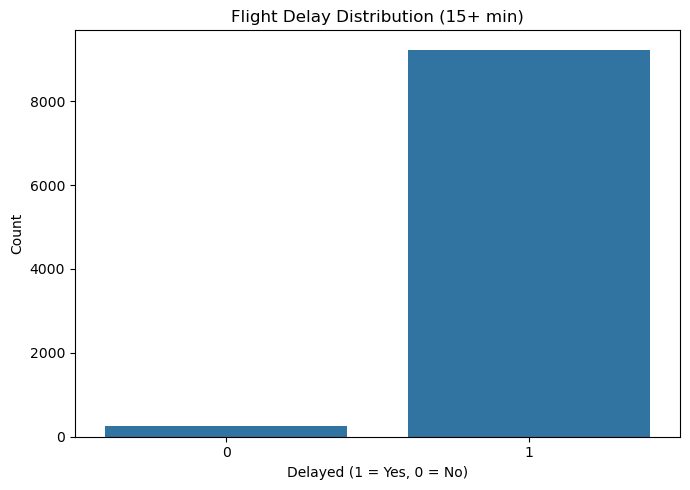

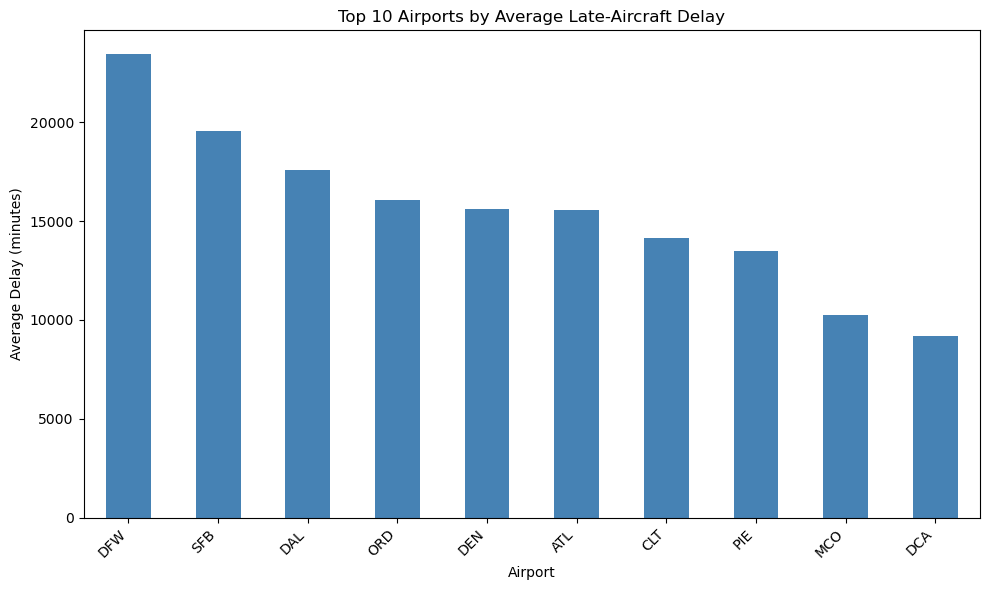

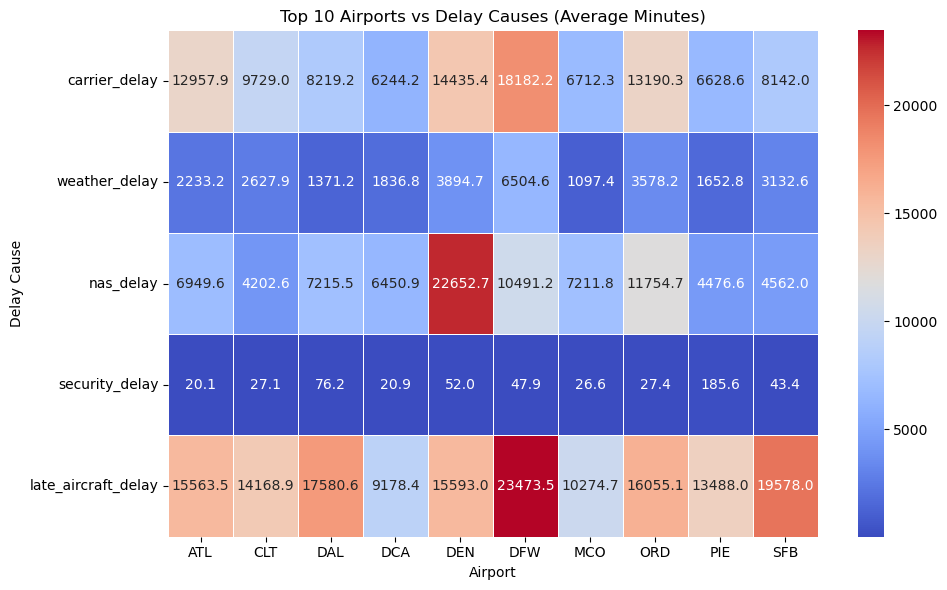

Updated EDA plots saved.

=== TRAINING MODELS ===

=== EVALUATION ===

MODEL: Logistic Regression
Accuracy: 0.9747155499367889
Precision: 0.9762510602205259
Recall: 0.9982653946227233

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.16      0.27        67
           1       0.98      1.00      0.99      2306

    accuracy                           0.97      2373
   macro avg       0.85      0.58      0.63      2373
weighted avg       0.97      0.97      0.97      2373


MODEL: Random Forest
Accuracy: 0.9730299199325748
Precision: 0.9827734711455641
Recall: 0.98959236773634

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.40      0.46        67
           1       0.98      0.99      0.99      2306

    accuracy                           0.97      2373
   macro avg       0.76      0.70      0.72      2373
weighted avg       0.97      0.97      0.97      2373


=== E

NameError: name 'run_dbscan_flight_anomaly_detection' is not defined

In [7]:
# main.py
# CAP 4770 Final Project – Flight Delay Prediction
# Group: Ryan Blankenbeker, Kenyen Hast-Otero, John WG Wallace


def main():

    USE_MYSQL = True

    try:
        if USE_MYSQL:
            df = load_flight_data_mysql(
                host=MYSQL_HOST,
                user=MYSQL_USER,
                password=MYSQL_PASSWORD,
                database=MYSQL_DATABASE,
                table=MYSQL_TABLE
            )
        else:
            raise Exception("Forcing CSV mode")

    except Exception as e:
        print("\nMySQL not available. Falling back to CSV.")
        print("Reason:", e)
        df = load_flight_data("Airline_Delay_Cause.csv")

    print("\n=== PREPROCESSING ===")
    df = preprocess_data(df)
    df = create_delay_label(df)

    print("\n=== EXPLORATORY DATA ANALYSIS (EDA) ===")
    run_eda(df)

    print("\n=== TRAINING MODELS ===")
    models, X_test, y_test = train_models(df)

    print("\n=== EVALUATION ===")
    evaluate_models(models, X_test, y_test)

    print("\n=== ANOMALY DETECTION ===")
    run_dbscan_flight_anomaly_detection(df)



if __name__ == "__main__":
    main()
